In [7]:
import importlib
import sys
from urllib.request import urlretrieve

# Imports.
import numpy as np
import meshcat
from ipywidgets import interact, FloatSlider, ToggleButton
from IPython.display import display

import pydrake.all
from pydrake.all import (AddMultibodyPlantSceneGraph, DiagramBuilder, PlanarSceneGraphVisualizer, SceneGraph, Simulator)
from pydrake.systems.jupyter_widgets import WidgetSystem
from pydrake.examples.pendulum import PendulumGeometry, PendulumPlant

import underactuated
from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend, running_as_notebook
import underactuated.meshcat_utils as mutil
from pydrake.examples.pendulum import PendulumGeometry, PendulumPlant, PendulumInput
from pydrake.all import Linearize, LinearQuadraticRegulator,VectorSystem
import math
from pydrake.all import Jacobian, MathematicalProgram, Solve, Variables, Polynomial
import numpy as np
from pydrake.examples.pendulum import PendulumParams

In [8]:
### Prepare non-linear system
from pydrake.all import Variable, SymbolicVectorSystem, RegionOfAttraction
prog = MathematicalProgram()

# non-linear dyamics
s = prog.NewIndeterminates(1, "s")[0]
c = prog.NewIndeterminates(1, "c")[0]
theta = prog.NewIndeterminates(1, "theta")[0]
thetadot = prog.NewIndeterminates(1, "thetadot")[0]
x = np.array([s, c, theta, thetadot])

# control input with reference
u = ( - 2.4259662559187145 * thetadot - 10.741011052080012 * theta) 



In [9]:
### f(x,u) poly normalization

# Write out the dynamics in terms of sin(theta), cos(theta), and thetadot

p = PendulumParams()
f = [
    c * thetadot, -s * thetadot, thetadot,
    (u + (-p.damping() * thetadot + p.mass() * p.gravity() * p.length() * s) / (p.mass() * p.length() * p.length()))
]

In [10]:
### Find Lyapunov function

# The fixed-point in this coordinate (because cos(pi)=-1).
x0 = np.array([0, 1, 0, 0])

# Construct a polynomial V that contains all monomials with s,c,thetadot up
# to degree 2.
deg_V = 2
V = prog.NewFreePolynomial(Variables(x), deg_V).ToExpression()

# Add a constraint to enforce that V is strictly positive away from x0.
# radically unbounded for global stable
# not sure is needed here
eps = 1e-4
constraint1 = prog.AddSosConstraint(V - eps * (x - x0).dot(x - x0))

# Construct the polynomial which is the time derivative of V.
Vdot = V.Jacobian(x).dot(f)

# Construct a polynomial L representing the "Lagrange multiplier".
deg_L = 2
L = prog.NewFreePolynomial(Variables(x), deg_L).ToExpression()
l = prog.NewSosPolynomial(Variables(x), deg_L)[0].ToExpression()

# Add a constraint that Vdot is strictly negative away from x0 (but make an
# exception for the upright fixed point by multipling by s^2).
constraint2 = prog.AddSosConstraint(-Vdot - l * (s**2 + c**2 - 1))



# Call the solver.
result = Solve(prog)

# Print result
if (result.is_success()):
    print(f"Verified that {str(V)} is in the region of attraction.")
    #print(Polynomial(result.GetSolution(lambda_)))
else:
    print("failed")

Verified that (a(14) + (s(0) * c(0) * a(8)) + (s(0) * theta(0) * a(7)) + (s(0) * thetadot(0) * a(6)) + (s(0) * a(13)) + (pow(s(0), 2) * a(9)) + (c(0) * theta(0) * a(4)) + (c(0) * thetadot(0) * a(3)) + (c(0) * a(12)) + (pow(c(0), 2) * a(5)) + (theta(0) * thetadot(0) * a(1)) + (theta(0) * a(11)) + (pow(theta(0), 2) * a(2)) + (thetadot(0) * a(10)) + (pow(thetadot(0), 2) * a(0))) is in the region of attraction.


In [11]:
print("V =")
Vsol = Polynomial(result.GetSolution(V))
print(Vsol.RemoveTermsWithSmallCoefficients(1e-2))

V =
67973.882728795797*1 + 2219.6739088638674*thetadot(0)^2 + 0.011181469342444373*theta(0) * thetadot(0) + 23841.572331127125*theta(0)^2 + 87100.111504810848*c(0) + 49043.776736178792*c(0)^2 + -0.020424563863029033*s(0) * thetadot(0) + 49043.776736226071*s(0)^2


Mechanical Energy = 
(4.9050000000000002 * (1 - c(0)) + 0.125 * pow(thetadot(0), 2))


Text(0.5,1,'V (solid) and Mechanical Energy (dashed)')

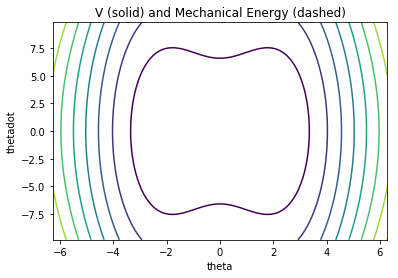

In [12]:
import matplotlib.pyplot as plt

mgl = p.mass() * p.gravity() * p.length()
print("Mechanical Energy = ")
print(.5 * p.mass() * p.length()**2 * thetadot**2 + mgl * (1 - c))

# Plot the results as contour plots.
nq = 151
nqd = 151
q = np.linspace(-2 * np.pi, 2 * np.pi, nq)
qd = np.linspace(-2 * mgl, 2 * mgl, nqd)
Q, QD = np.meshgrid(q, qd)
Energy = .5 * p.mass() * p.length()**2 * QD**2 + mgl * (1 - np.cos(Q))
Vplot = Q.copy()
env = {s: 0., c: 1., theta:0., thetadot: 0}
for i in range(nq):
    for j in range(nqd):
        env[s] = np.sin(Q[i, j])
        env[c] = np.cos(Q[i, j])
        env[theta] = Q[i,j]
        env[thetadot] = QD[i, j]
        Vplot[i, j] = Vsol.Evaluate(env) 

# plt.rc("text", usetex=True)
fig, ax = plt.subplots()
ax.contour(Q, QD, Vplot)
# ax.contour(Q, QD, Energy, alpha=0.5, linestyles="dashed")
ax.set_xlabel("theta")
ax.set_ylabel("thetadot")
ax.set_title("V (solid) and Mechanical Energy (dashed)")